In [1]:
%matplotlib inline
import sys, os
# sys.path.append("../")
import numpy as np
import cupy as cp
import scipy as sp
import numpy.linalg as nla
from cupyx.time import repeat
import matplotlib.pyplot as plt
import ot
import ot.gpu
from ot.datasets import make_1D_gauss as gauss
import matplotlib as mpl
import matplotlib.pyplot as plt
from timeit import timeit
import csv
%load_ext autoreload
%autoreload 2

## Generate data



In [4]:
def save(C, nrows, ncols, filename):
    assert C.flags['F_CONTIGUOUS']   
    output_file = open(filename, 'wb')
    C.tofile(output_file)
    output_file.close()
def readcsv(filename):
    f = [];
    with open(filename) as csvfile:
        csvReader = csv.reader(csvfile, delimiter=",")
        next(csvReader)  # skip the header
        for row in csvReader:
            f.append(float(row[0]))
    return np.asarray(f, dtype=np.float32)

# def two_dimensional_gaussian_ot_64(m, n):
#     mu_s = np.array([0, 0.5])
#     cov_s = np.array([[1, 0.5], [0.5, 1]])
#     mu_t = np.array([4, 10])
#     cov_t = np.array([[1, -.8], [-.8, 1]])
#     xs = ot.datasets.make_2D_samples_gauss(m, mu_s, cov_s)
#     xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)
#     p, q = np.ones((m,)) / m, np.ones((n,)) / n  
#     C = np.array(ot.dist(xs, xt), order='F')
#     C /= C.max()
#     C32 = np.array(C, order='F').astype(np.float32)
#     save(C32, m, n, "../gpu/data/cmatrix")
#     return m, n, C, p, q

def two_dimensional_gaussian_ot(m, n):
    mu_s = np.array([0, 0.5])
    cov_s = np.array([[1, 0.5], [0.5, 1]])
    mu_t = np.array([4, 10])
    cov_t = np.array([[1, -.8], [-.8, 1]])
    xs = ot.datasets.make_2D_samples_gauss(m, mu_s, cov_s)
    xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)
    p, q = np.ones((m,)).astype(np.float32) / m, np.ones((n,)).astype(np.float32) / n  
    C = np.array(ot.dist(xs, xt), order='F').astype(np.float32)
    C /= C.max()
    return m, n, C, p, q

In [224]:
m, n, C, p, q = two_dimensional_gaussian_ot_64(1000, 1000)

## Compute EMD for the different losses



In [225]:
femd = ot.emd2(p, q, C.copy(), numItermax=100000)  # direct computation of EMD

### Single run

Text(0, 0.5, 'Primal Residual')

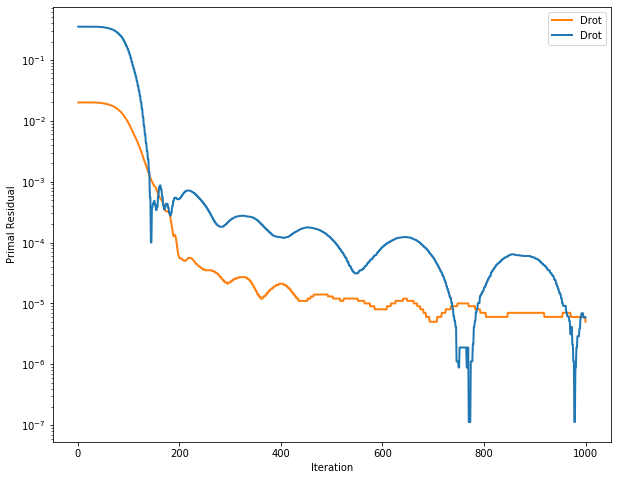

In [155]:
filenames = [ '../gpu/output/' + 'drot_5000_0.000010.csv' ];
labels = ['Drot']
colors = ['C0', 'C1']
markers = ['', '']
fig1 = plt.figure(figsize=(10, 8))

optval = femd

for i in range(len(filenames)):
    k = []; t = []; r = []; f = [];
    with open(filenames[i]) as csvfile:
        csvReader = csv.reader(csvfile, delimiter=",")
        next(csvReader)  # skip the header
        for row in csvReader:
            k.append(int(row[0]))
            t.append(float(row[1]))
            r.append(float(row[2]))
            f.append(float(row[3]))

        plt.plot(k, [res for res in r], color=colors[i+1], marker=markers[i], label=labels[i], linewidth=2)
        plt.plot(k, [abs(fval - optval) for fval in f], color=colors[i], marker=markers[i], label=labels[i], linewidth=2)


plt.yscale('log')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Primal Residual")

Text(0, 0.5, 'Primal Residual')

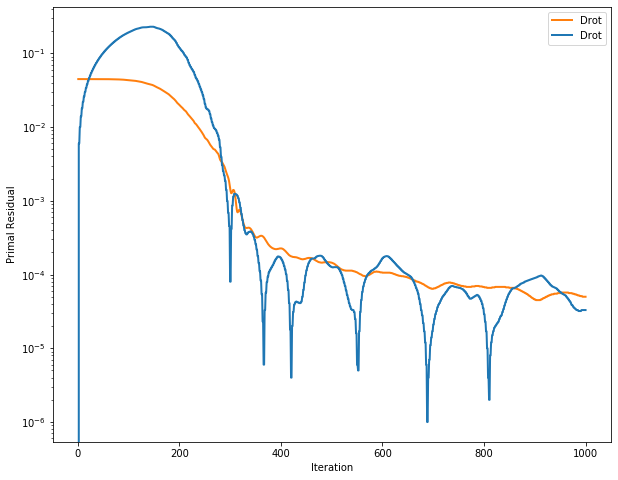

In [228]:
filenames = [ '../gpu/output/' + 'drot_1000_0.000500.csv' ];
labels = ['Drot']
colors = ['C0', 'C1']
markers = ['', '']
fig1 = plt.figure(figsize=(10, 8))

for i in range(len(filenames)):
    k = []; t = []; r = []; g = [];
    with open(filenames[i]) as csvfile:
        csvReader = csv.reader(csvfile, delimiter=",")
        next(csvReader)  # skip the header
        for row in csvReader:
            k.append(int(row[0]))
            t.append(float(row[1]))
            r.append(float(row[2]))
            g.append(float(row[3]))

        plt.plot(k, [res for res in r], color=colors[i+1], marker=markers[i], label=labels[i], linewidth=2)
        plt.plot(k, [abs(gap-optval) for gap in g], color=colors[i], marker=markers[i], label=labels[i], linewidth=2)


plt.yscale('log')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Primal Residual")

## Performance profile

In [33]:
def multi_experiment(m, n, max_iters, accuracies, skregs, alpha=1.0, ntests=20, verbskip=1):
    num_accuracies = accuracies.shape[0]
    num_algs = skregs.shape[0] + 1
    outs = np.zeros([num_algs, 1, num_accuracies, ntests])
    optvals = []
    
    for test_idx in range(ntests):
        print("\n *** Experiment", test_idx+1, "of", ntests, "***")

        m, n, C, p, q = two_dimensional_gaussian_ot(m, n)
        filename = "data/cmatrix_" + str(m) + '_test_' + str(test_idx)
        assert(C.dtype==np.float32)
        save(C, m, n, filename)

        x0 = np.array(np.outer(p, q), order = 'F')
        step = alpha / (m+n)
        
        C_ = C.copy()
        G0 = ot.emd(p, q, C_, numItermax=1_000_000)
        optval = np.sum(G0 * C_)
        optvals.append(optval)
        
        skout = []                        
        for reg in skregs:
            skout.append(sinkhorn_knopp(p, q, C_, reg, numItermax=1000, stopThr=1e-4))
        
        for sk_idx, fval in enumerate(skout):
            outs[sk_idx+1, 0, :, test_idx] = abs(np.sum(fval*C_) - optval) / optval

    file_name = 'Dims_' + str(m) + '_test_' + str(ntests)
    np.save('output/'+file_name + '.npy', outs)
    return file_name, optvals

def profile(dir, accuracies, optvals, labels, colors):         
    outs = np.load(dir)
    (num_algs, num_objs_computed, num_accuracies, ntests) = outs.shape
    performance_ratio = np.zeros((num_algs, num_accuracies))

    # Read DROT's data
#     filename = 'output/drot_' + str(m) + '_' + str(ntests) + '.csv'
#     drout = readcsv(filename)
#     for test_idx in range(drout.shape[0]):
#             outs[0, 0, :, test_idx] = abs(np.sum(drout[test_idx]*C) - optval) / optval
    
    for alg_idx in range(num_algs):
        for acc_idx in range(num_accuracies):
            performance_ratio[alg_idx, acc_idx] = np.sum((outs[alg_idx, 0, acc_idx, :] <= accuracies[acc_idx])) / ntests

    fig = plt.figure()        
    for alg_idx in range(num_algs):
        plt.plot(accuracies, performance_ratio[alg_idx, :], color=colors[alg_idx], label=labels[alg_idx], linewidth=2.5)
  
    ylabel = r'Performance ratio'
    plt.xlabel(r'Final accuracy')
    plt.ylabel(ylabel)
    plt.xscale('log')
    plt.legend()
        
    return fig

In [34]:
m, n = 500, 500
max_iters = 1000
accuracies = np.logspace(-4.5, -1, num=15)
skregs = np.array([1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1])

file_name, optvals = multi_experiment(m, n, max_iters, accuracies, skregs, alpha=2, ntests=50)


 *** Experiment 1 of 50 ***

 *** Experiment 2 of 50 ***

 *** Experiment 3 of 50 ***

 *** Experiment 4 of 50 ***

 *** Experiment 5 of 50 ***

 *** Experiment 6 of 50 ***

 *** Experiment 7 of 50 ***

 *** Experiment 8 of 50 ***

 *** Experiment 9 of 50 ***

 *** Experiment 10 of 50 ***

 *** Experiment 11 of 50 ***

 *** Experiment 12 of 50 ***

 *** Experiment 13 of 50 ***

 *** Experiment 14 of 50 ***

 *** Experiment 15 of 50 ***

 *** Experiment 16 of 50 ***

 *** Experiment 17 of 50 ***

 *** Experiment 18 of 50 ***

 *** Experiment 19 of 50 ***

 *** Experiment 20 of 50 ***

 *** Experiment 21 of 50 ***

 *** Experiment 22 of 50 ***

 *** Experiment 23 of 50 ***

 *** Experiment 24 of 50 ***

 *** Experiment 25 of 50 ***

 *** Experiment 26 of 50 ***

 *** Experiment 27 of 50 ***

 *** Experiment 28 of 50 ***

 *** Experiment 29 of 50 ***

 *** Experiment 30 of 50 ***

 *** Experiment 31 of 50 ***

 *** Experiment 32 of 50 ***

 *** Experiment 33 of 50 ***

 *** Experiment 34

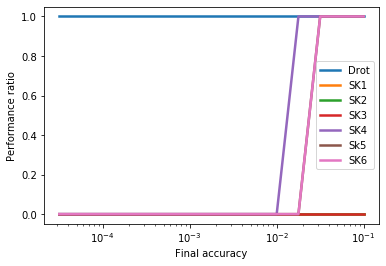

In [35]:
labels = ['Drot', 'SK1', 'SK2', 'SK3', 'SK4', 'Sk5', 'SK6']
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
dir = "output/" + file_name  + '.npy'
fig = profile(dir, accuracies, optvals, labels, colors)


## Compute Sinkhorn for the different losses



In [18]:
reg = 0.01
# x_sk = ot.sinkhorn(p, q, C.copy(), reg)
# x_gpu = ot.gpu.sinkhorn(p, q, C, reg)

x_gpu = sinkhorn_knopp(p, q, C.copy(), reg, numItermax=1000, stopThr=1e-4)

NumIter:  10


In [79]:
%timeit x_sk = ot.sinkhorn(p, q, C, reg, stopThr=1e-4)

651 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
# d_sk = np.sum(x_sk*C) 
d_gpu = cp.sum(x_gpu*C)

d_emd, d_sk, d_gpu

(0.39248813228914514, 0.40523145572242397, 0.39830318)

In [20]:
(d_sk-d_emd)/d_emd

0.032468047782629135

In [72]:
def run_sk(p, q, C, reg):
    sinkhorn_knopp(p, q, C, reg, numItermax=1000, stopThr=1e-4, to_numpy=False)
print(repeat(run_sk, (p, q, C, 1e-2), n_repeat=1))      

NumIter:  10
NumIter:  10
NumIter:  10
NumIter:  10
NumIter:  10
NumIter:  10
NumIter:  10
NumIter:  10
NumIter:  10
NumIter:  10
NumIter:  10
run_sk              :    CPU:75640.623 us     GPU-0:79221.024 us


In [ ]:
%timeit sinkhorn_knopp(p, q, C, reg, numItermax=100, stopThr=1e-4, to_numpy=False)

In [32]:
def sinkhorn_knopp(a, b, M, reg, numItermax=1000, stopThr=1e-9,
                   verbose=False, log=False, to_numpy=True, **kwargs):
   
    a = cp.asarray(a)
    b = cp.asarray(b)
    M = cp.asarray(M)

    if len(a) == 0:
        a = cp.ones((M.shape[0],), dtype=M.dtype) / M.shape[0]
    if len(b) == 0:
        b = cp.ones((M.shape[1],), dtype=M.dtype) / M.shape[1]

    # init data
    Nini = len(a)
    Nfin = len(b)

    if log:
        log = {'err': []}

    u = cp.ones(Nini, dtype=M.dtype) / Nini
    v = cp.ones(Nfin, dtype=M.dtype) / Nfin

    # Next 3 lines equivalent to K= cp.exp(-M/reg), but faster to compute
    K = cp.empty(M.shape, dtype=M.dtype)
    cp.divide(M, -reg, out=K)
    cp.exp(K, out=K)

    tmp1 = cp.empty(a.shape, dtype=M.dtype)
    tmp2 = cp.empty(b.shape, dtype=M.dtype)

    Kp = (1 / a).reshape(-1, 1) * K
     
    cpt = 0  # CPU
    err = 1
    while (err > stopThr and cpt < numItermax):
        uprev = u
        vprev = v

        KtransposeU = cp.dot(K.T, u)
        v = cp.divide(b, KtransposeU)
        u = 1. / cp.dot(Kp, v)

        if (cp.any(KtransposeU == 0) or
                cp.any(cp.isnan(u)) or cp.any(cp.isnan(v)) or
                cp.any(cp.isinf(u)) or cp.any(cp.isinf(v))):
            # we have reached the machine precision
            # come back to previous solution and quit loop
            print('Warning: numerical errors at iteration', cpt)
            u = uprev
            v = vprev
            break
        if cpt % 10 == 0:
            # we can speed up the process by checking for the error only all
            # the 10th iterations

            # compute right marginal tmp2= (diag(u)Kdiag(v))^T1
            tmp1 = cp.sum(u[:, None] * K * v[None, :], 1)
            tmp2 = cp.sum(u[:, None] * K * v[None, :], 0)
#             tmp2 = cp.einsum('i,ij,j->j', u, K, v)
            err = cp.sqrt(cp.linalg.norm(tmp1 - a)**2 
                          + cp.linalg.norm(tmp2 - b)**2)  # violation of marginal

            if log:
                log['err'].append(err)

        cpt += 1
        
    if log:
        log['u'] = u
        log['v'] = v

 
    res = u.reshape((-1, 1)) * K * v.reshape((1, -1))
    if to_numpy:
        res = to_np(res)
    if log:
        return res, log
    else:
        return res


In [7]:

def euclidean_distances(a, b, squared=False, to_numpy=True):
    """
    Compute the pairwise euclidean distance between matrices a and b.
    If the input matrix are in numpy format, they will be uploaded to the
    GPU first which can incur significant time overhead.
    Parameters
    ----------
    a : np.ndarray (n, f)
        first matrix
    b : np.ndarray (m, f)
        second matrix
    to_numpy : boolean, optional (default True)
        If true convert back the GPU array result to numpy format.
    squared : boolean, optional (default False)
        if True, return squared euclidean distance matrix
    Returns
    -------
    c : (n x m) np.ndarray or cupy.ndarray
        pairwise euclidean distance distance matrix
    """

    a, b = to_gpu(a, b)

    a2 = np.sum(np.square(a), 1)
    b2 = np.sum(np.square(b), 1)

    c = -2 * np.dot(a, b.T)
    c += a2[:, None]
    c += b2[None, :]

    if not squared:
        np.sqrt(c, out=c)
    if to_numpy:
        return to_np(c)
    else:
        return c


def dist(x1, x2=None, metric='sqeuclidean', to_numpy=True):
    """Compute distance between samples in x1 and x2 on gpu
    Parameters
    ----------
    x1 : np.array (n1,d)
        matrix with n1 samples of size d
    x2 : np.array (n2,d), optional
        matrix with n2 samples of size d (if None then x2=x1)
    metric : str
        Metric from 'sqeuclidean', 'euclidean',
    Returns
    -------
    M : np.array (n1,n2)
        distance matrix computed with given metric
    """
    if x2 is None:
        x2 = x1
    if metric == "sqeuclidean":
        return euclidean_distances(x1, x2, squared=True, to_numpy=to_numpy)
    elif metric == "euclidean":
        return euclidean_distances(x1, x2, squared=False, to_numpy=to_numpy)
    else:
        raise NotImplementedError


def to_gpu(*args):
    """ Upload numpy arrays to GPU and return them"""
    if len(args) > 1:
        return (cp.asarray(x) for x in args)
    else:
        return cp.asarray(args[0])


def to_np(*args):
    """ convert GPU arras to numpy and return them"""
    if len(args) > 1:
        return (cp.asnumpy(x) for x in args)
    else:
        return cp.asnumpy(args[0])

In [ ]:
m, n = 4, 20
A = np.random.randn(m, n)
e = np.ones(n)
f = np.ones(m)
yy = np.random.randn(m,1)
xx = np.random.randn(n)
assert np.allclose(A - np.outer(yy, e) - np.outer(f, xx), A - yy - xx)
D = np.outer(yy, e) + np.outer(f, xx)
[np.allclose(D[i, j], yy[i] + xx[j]) for i, j in zip(range(yy.size), range(xx.size))]

np.outer(yy, e)
np.outer(f, xx)
D = np.outer(yy, e) + np.outer(f, xx)
[np.allclose(D[i, j], yy[i] + xx[j]) for i, j in zip(range(yy.size), range(xx.size))]
i, j = 3, 4

D[i, j], yy[i] + xx[j]

In [ ]:
def run_max(X):
    return cp.asarray(X)
run_max(C)

print(repeat(run_max, (C,), n_repeat=1))  
def run_gemv(A, x):
    return A.T.dot(x), A.dot(x)

C_ = run_max(C)
p_ = cp.asarray(p)

print(C_.device)

print(repeat(run_gemv, (C_, p_), n_repeat=1))  
def run_exp(M, x, reg=1e-2):
    K = cp.empty(M.shape, dtype=M.dtype)
    cp.divide(M, -reg, out=K)
    cp.exp(K, out=K)
    o = K.T.dot(x)

print(repeat(run_exp, (C_, p_, 1e-2), n_repeat=1))     

def run_setup(a, b, M, reg):
    a = cp.asarray(a)
    b = cp.asarray(b)
    M = cp.asarray(M)

    if len(a) == 0:
        a = cp.ones((M.shape[0],), dtype=M.dtype) / M.shape[0]
    if len(b) == 0:
        b = cp.ones((M.shape[1],), dtype=M.dtype) / M.shape[1]

    # init data
    Nini = len(a)
    Nfin = len(b)

    u = cp.ones(Nini, dtype=M.dtype) / Nini
    v = cp.ones(Nfin, dtype=M.dtype) / Nfin

    K = cp.empty(M.shape, dtype=M.dtype)
    cp.divide(M, -reg, out=K)
    cp.exp(K, out=K)
    
    tmp1 = cp.empty(a.shape, dtype=M.dtype)
    tmp2 = cp.empty(b.shape, dtype=M.dtype)

    Kp = (1 / a).reshape(-1, 1) * K
    
    uprev = u
    vprev = v
    
    KtransposeU = cp.dot(K.T, u)
    v = b / KtransposeU
    u = 1. / cp.dot(Kp, v)

print(repeat(run_setup, (p, q, C, 1e-2), n_repeat=20))        
